## Vectorized energy minimization with  a `pandas` graph representation   

In [1]:
%load_ext autoreload

%autoreload 2

%load_ext snakeviz

from scipy import optimize
import graph_tool.all as gt
import pandas as pd
from leg_joint.pandas_geometry import Triangles, parse_graph
from numpy.testing import assert_almost_equal, assert_array_almost_equal

import vispy as vp
#vp.use('ipynb_webgl')

from vispy import app, gloo, visuals
from vispy.geometry import MeshData
from vispy import plot


%run nb_init.py

2015-02-24 01:29:53,682 -leg_joint -<module> -- INFO -successfully imported leg_joint


In [2]:
eptm = lj.Epithelium(lj.data.before_apoptosis_xml())

2015-02-24 01:29:53,797 -leg_joint.epithelium -__init__ -- INFO -Instanciating epithelium 0
2015-02-24 01:29:55,143 -leg_joint.epithelium -__init__ -- INFO -Initial cells
2015-02-24 01:29:55,144 -leg_joint.epithelium -__init__ -- INFO -Initial junctions
2015-02-24 01:30:03,058 -leg_joint.epithelium -__init__ -- INFO -Update geometry


### Previous method 

In [3]:
eptm.isotropic_relax()

### uncomment bellow to select a random cell

#rand_cell = np.random.randint(1, eptm.is_cell_vert.a.sum())
rand_cell = 498 # Fair dice the first time
print(rand_cell)

# that's the begining of cell division

mother_cell = eptm.graph.vertex(rand_cell)
area0 = eptm.cells.areas[mother_cell]
growth_rate = 1.5
eptm.cells.prefered_vol[mother_cell] *= growth_rate



498


In [4]:
eptm.set_local_mask(mother_cell, wider=True)

eptm.update_geometry()
eptm.update_gradient()



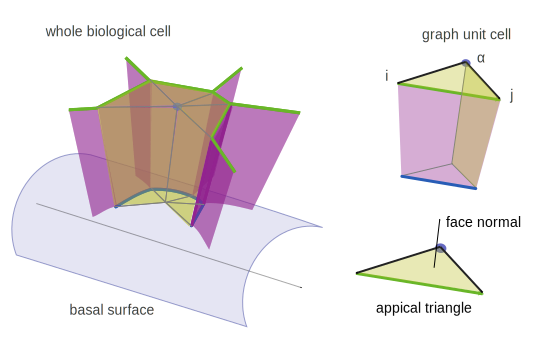

In [5]:
disp.SVG(lj.data.get_image('pandas_geometry_full.svg'))

In [6]:

### Active vertices can be moved during optimization
### Only junction vertices are allowed to move

eptm.is_active_vert.a = (1 - eptm.is_cell_vert.a)*eptm.is_alive.a

vertex_df_full, edges_df_full, triangles_full = parse_graph(eptm.graph)
coords = ['ixs', 'wys', 'zeds']
trgles = Triangles(vertex_df_full, edges_df_full, triangles_full, coords)


trgles.geometry(eptm.rho_lumen)

### The `Triangles` class

In [19]:
print(Triangles.__doc__)


    Data structure defined to index the ensembles of sub-graph homologue to
    this topology:

     jv_i (i) -- > (j) jv_j
           ^       ^
            \     /
             \   /
              (a) cell

    In the 3D coordinate system, this represents an oriented
    triangular face.  Note that as long as the cell to junction edges
    go outward from the cell, the complete epithelium is a unique
    set of faces homologue to this topology (regardess of the
    orientation of jv_i and jv_j) thus the triangle is the unit cell
    of the geometrical network - in the cristalography sense of unit
    cell.

    Methods
    -------



    


In [ ]:
## %%snakeviz
## For some reason 'BFGS' is **much** slower than **L-BFGS-B**
## with lots of overhead outside function and gradient calls (We're talking 85% of the computation time here!!!)
## All that time is spent calling numpy.dot (see scipy/opitmize/optimize.py l.797)
## Might be worth pointing that out to the scipy folks

## The optimization takes about 200 s here. A typical joint formation scenario
## Should thus take about (200  * 11 * 30) s, ie 110 min, or 2h
pos0 = trgles.vertex_df.loc[trgles.uix_active, coords].values.flatten()
p_out = optimize.minimize(lj.pandas_geometry.opt_energy,
                          pos0, method='L-BFGS-B',
                          jac=lj.pandas_geometry.opt_gradient,
                          args=(trgles, eptm.norm_factor, eptm.rho_lumen),
                          options={'gtol': 1e-3, 'disp': False})


Code updating the graph vertex properties

```python
eptm.graph.set_vertex_filter(None)
eptm.graph.set_edge_filter(None)

lj.pandas_geometry.update_graph(trgles, eptm.graph)
```



### Data representation 

In [14]:
def get_outward_faces(trgles):
    '''
    Return a copy of the `Triangles` intance multi-index
    swaped such that the order of the vertex indexes is
    oriented outward (away from the basal surface)
    
    Consider the vector going from the basal surface to the
    apical center of the cell. The sign of the scalar product
    of this vector with the normal to the surface is positive
    if the triangle is correctly oriented and negative in the
    oposite case.

    
    Returns
    -------
    
    out_faces: ndarray with shape (N_t, 3)
      where N_t is the number of triangles in the tissue
    
    '''
    ## Apico basal vector
    
    ab_vect = trgles.tdf_cell[trgles.coords].copy()
    ### In the cylindrical coordinate, suffice to 
    ### get the projection on the z axis
    ab_vect['zeds'] = 0
    ab_vect.set_index(trgles.tix_aij,
                      inplace=True)
    
    normals = trgles.faces[trgles.normal_coords].values
    
    ## This is +/-1 depending on orientation
    trgles.faces["orientation"] = np.sign((ab_vect*normals).sum(axis=1))
    out_faces = []
    for f, o in zip(trgles.tix_aij.values,
                    trgles.faces.orientation):
        _f = list(f) if o > 0 else [f[0], f[2], f[1]]
        
        out_faces.append(_f)

    return np.asarray(out_faces)

out_faces = get_outward_faces(trgles)
                           
### We swap the x and z axis for a better orientation

positions = trgles.vertex_df[[trgles.coords[2], 
                              trgles.coords[1],
                              trgles.coords[0]]].sort_index().values

### Vispy meshdata                           
mdata = MeshData(vertices=positions,
                 faces=out_faces)

### A raw visualisation in vispy

In [15]:
canvas = plot.mesh(meshdata=mdata,
                   azimuth=0,
                   elevation=60,
                   distance=100.0)

canvas.show()
canvas.app.run()


  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)

  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)



0

Method to copy the gradient array to the graph PropertyMap

```python
eptm.graph.set_vertex_filter(eptm.is_active_vert)
eptm.grad_ix.fa = grad.gixs
eptm.grad_zed.fa = grad.gzeds
eptm.grad_wy.fa = grad.gwys
eptm.graph.set_vertex_filter(None)

```

Here is a matplotlib method


```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(trgles.vertex_df.ixs,
        trgles.vertex_df.zeds, 'o')
for face in out_faces:
    a, i, j = face
    ax.plot([trgles.vertex_df.ixs[u] for u in face],
            [trgles.vertex_df.zeds[u] for u in face], 'k-')
```

In [17]:
trgles.geometry(eptm.rho_lumen)

In [49]:

assert_almost_equal(trgles.vertex_df.loc[mother_cell, 'vols'], eptm.cells.vols[mother_cell])
assert_almost_equal(trgles.vertex_df.loc[mother_cell, 'areas'], eptm.cells.areas[mother_cell])
assert_almost_equal(trgles.vertex_df.loc[mother_cell, 'perimeters'], eptm.cells.perimeters[mother_cell])

assert_almost_equal(trgles.edges_df.loc[(64, 70), 'edge_lengths'], eptm.edge_lengths[j_edge])


In [50]:
pos0 = trgles.vertex_df.loc[trgles.uix_active, coords].values.flatten()

In [51]:
%pdb

Automatic pdb calling has been turned ON


In [52]:
%%snakeviz

p_out = optimize.minimize(lj.pandas_geometry.opt_energy,
                          pos0, method='BFGS',
                          jac=lj.pandas_geometry.opt_gradient,
                          args=(trgles, eptm.norm_factor, eptm.rho_lumen),
                          options={'gtol': 1e-4, 'disp': False})

 
*** Profile stats marshalled to file '/tmp/tmpzyp7iqpm'. 


In [39]:
%%snakeviz

p_out = lj.find_energy_min(eptm)

 
*** Profile stats marshalled to file '/tmp/tmp6tpzwtqg'. 


In [24]:
%%snakeviz
out = lj.find_energy_min(eptm)

 
*** Profile stats marshalled to file '/tmp/tmpgzuyg5bq'. 


In [40]:
eptm.graph.set_vertex_filter(eptm.is_local_vert)
eptm.graph.set_edge_filter(eptm.is_local_edge)

lj.pandas_geometry.update_graph(trgles, eptm.graph)

eptm.graph.set_vertex_filter(None)
eptm.graph.set_edge_filter(None)



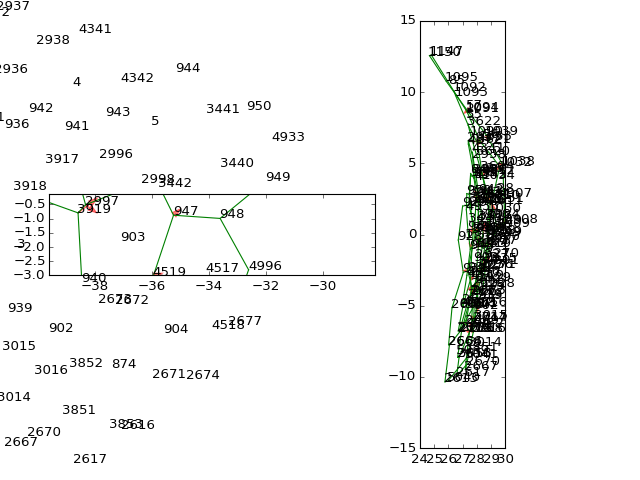

(<matplotlib.axes._subplots.AxesSubplot at 0x7fde3bda3cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde363c2550>)

In [26]:
%matplotlib nbagg
lj.plot_2pannels_gradients(eptm, scale=10, cell_kwargs={'j_text':True, 'c_text':True},)

In [83]:
eptm.graph.set_vertex_filter(eptm.is_local_vert)

for col in trgles.vertex_df.columns:
    data = trgles.vertex_df[col]
    try:
        eptm.graph.vp[col].fa = data
    except KeyError:
        print('Property {} not found'.format(col))
eptm.graph.set_vertex_filter(None)    

Property num_sides not found
Property heights not found


In [80]:
out = lj.find_energy_min(eptm)

In [76]:
trgles.vertex_df.ixs.loc[64]

3.9117867261484678

In [77]:
jv0

<Vertex object with index '64' at 0x7fc82d7dde58>

In [82]:
eptm.ixs[jv0]

3.5044020707532417

In [64]:
energy = trgles.energy()/ eptm.norm_factor


In [65]:
energy

10.097965497804429

In [66]:

eptm.graph.set_vertex_filter(eptm.is_local_vert)
eptm.graph.set_edge_filter(eptm.is_local_edge)
pos0, bounds = lj.optimizers.precondition(eptm)
eptm_e = lj.optimizers.opt_energy(pos0.flatten(), eptm)

assert_array_almost_equal(eptm_e, energy)
eptm.graph.set_vertex_filter(None)
eptm.graph.set_edge_filter(None)

In [67]:

juncs = eptm.graph.new_edge_property('bool')
juncs.a = eptm.is_junction_edge.a * eptm.is_local_edge.a

loc_cells = eptm.is_cell_vert.copy()
loc_cells.a *= eptm.is_local_vert.a

eptm.graph.set_vertex_filter(loc_cells)
assert_almost_equal(eptm.cells.vols.fa.sum(),
                    trgles.udf_cell['vols'].sum())
assert_almost_equal(eptm.cells.prefered_vol.fa.sum(),
                    trgles.udf_cell['prefered_vol'].sum())
assert_almost_equal(eptm.cells.contractilities.fa.sum(),
                    trgles.udf_cell['contractilities'].sum())
assert_almost_equal(eptm.cells.perimeters.fa.sum(),
                    trgles.udf_cell['perimeters'].sum())
eptm.graph.set_vertex_filter(None)



eptm.graph.set_edge_filter(juncs)
assert_almost_equal(eptm.junctions.line_tensions.fa.sum(),
                    trgles.udf_itoj['line_tensions'].sum())
assert_almost_equal(eptm.edge_lengths.fa.sum(),
                    trgles.udf_itoj['edge_lengths'].sum())
eptm.graph.set_edge_filter(None)

In [68]:
grad_i, grad_t, grad_c, grad_v = trgles.gradient(components=True)

In [71]:
%%snakeviz
optimize.check_grad(opt_energy, opt_gradient, pos0, trgles)

 
*** Profile stats marshalled to file '/tmp/tmpl2b2i1pb'. 


In [72]:
%%snakeviz
lj.optimizers.check_local_grad(eptm)

2015-02-09 15:50:07,463 -leg_joint.optimizers -check_local_grad -- INFO -Checking gradient


 
*** Profile stats marshalled to file '/tmp/tmpe1gy_5a6'. 


In [78]:
def grad_norm(eptm, jv):
    return (eptm.grad_ix[jv]**2 + eptm.grad_zed[jv]**2 + eptm.grad_wy[jv]**2)**0.5


In [80]:
grad_norm(eptm, jv1)


5157.763710626337

In [73]:

ctr_back = np.array(eptm.cells.contractilities.a)
el_back = np.array(eptm.cells.vol_elasticities.a)
tens_back = np.array(eptm.junctions.line_tensions.a)


eptm.cells.vol_elasticities.a[:] = 0
eptm.cells.contractilities.a[:] = 0
eptm.update_gradient()
e_grad_t_jv0 = np.array([eptm.grad_ix[jv0],
                         eptm.grad_wy[jv0],
                         eptm.grad_zed[jv0]])

eptm.cells.contractilities.a = ctr_back
eptm.junctions.line_tensions.a[:] = 0
eptm.update_gradient()
e_grad_c_jv0 = np.array([eptm.grad_ix[jv0],
                         eptm.grad_wy[jv0],
                         eptm.grad_zed[jv0]])

eptm.cells.contractilities.a[:] = 0
eptm.cells.vol_elasticities.a = el_back

eptm.update_gradient()
e_grad_v_jv0 = np.array([eptm.grad_ix[jv0],
                         eptm.grad_wy[jv0],
                         eptm.grad_zed[jv0]])

eptm.cells.contractilities.a = ctr_back
eptm.junctions.line_tensions.a = tens_back

eptm.update_gradient()
e_grad_i_jv0 = np.array([eptm.grad_ix[jv0],
                         eptm.grad_wy[jv0],
                         eptm.grad_zed[jv0]])

In [74]:
print('tension')
print(e_grad_t_jv0)
print('contractility')
print(e_grad_c_jv0)
print('volume')
print(e_grad_v_jv0)
print('total')
print(e_grad_i_jv0)

tension
[ 895.54080344  370.94514644   13.87555795]
contractility
[ 1979.01979205   819.73683807    30.66304036]
volume
[-2044.95633921 -5444.09203774  2752.3858182 ]
total
[  829.60425628 -4253.41005323  2796.92441652]


In [75]:
print('tension')
print(grad_t.loc[jv0_idx].values)
print('contractility')
print(grad_c.loc[jv0_idx].values)
print('volume')
print(grad_v.loc[jv0_idx].values)
print('total')
print(grad_i.loc[jv0_idx].values)

tension
[ 895.54080344  370.94514644   13.87555795]
contractility
[ 1979.01979205   819.73683807    30.66304036]
volume
[-2044.95633921 -5444.09203774  2752.3858182 ]
total
[  829.60425628 -4253.41005323  2796.92441652]



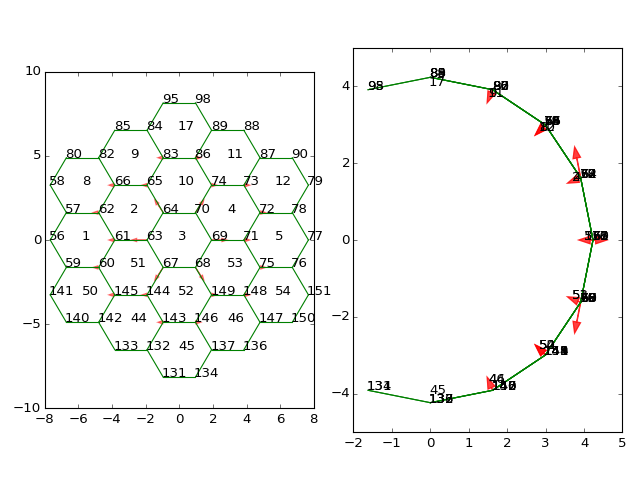

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5650cdbf28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5650ae6dd8>)

In [76]:
%matplotlib nbagg
lj.plot_2pannels_gradients(eptm, scale=10, cell_kwargs={'j_text':True, 'c_text':True},)


### Usage example

```python
### cells only on the vertex dataframe
cell_verts = trgles.udf_cell['is_cell_vert']

### upcasted
tri_cell_rhos =  trgles.tdf_cell['rhos']

### Insert upcasted values to the faces dataframe
trgles.faces['cell_rhos'] = tri_cell_rhos.values

### Some benchmarks
print('unique cells - pure pandas')
%timeit vertex_df.loc[cell_idxs, 'is_cell_vert']
print('unique cells - full indexation')
%timeit trgles.vertex_df.loc[trgles.uix_a, 'is_cell_vert']
print('unique cells - DataView')
%timeit trgles.udf_cell['is_cell_vert']
###
print('triangle cells - pure pandas')
%timeit vertex_df.loc[tri_cells, 'is_cell_vert']
print('triangle cells - full indexation')
%timeit trgles.vertex_df.loc[trgles.tix_a, 'is_cell_vert']
print('triangle cells - DataView')
%timeit trgles.tdf_cell['is_cell_vert']

unique cells - pure pandas
1000 loops, best of 3: 327 µs per loop
unique cells - full indexation
1000 loops, best of 3: 388 µs per loop
unique cells - DataView
1000 loops, best of 3: 393 µs per loop
triangle cells - pure pandas
1000 loops, best of 3: 477 µs per loop
triangle cells - full indexation
1000 loops, best of 3: 471 µs per loop
triangle cells - DataView
1000 loops, best of 3: 474 µs per loop
```


```python
>>> %timeit trgles.uix_a
>>> %timeit trgles.vertex_df.loc[trgles.uix_a, 'is_cell_vert']
>>> %timeit vertex_df.loc[cell_idxs, 'is_cell_vert']


10000000 loops, best of 3: 88.7 ns per loop
1000 loops, best of 3: 620 µs per loop
1000 loops, best of 3: 526 µs per loop
```

A 80 µs overhead is ok I guess, given the gain in code readability


## Gradient computation at junction vertices

In order to find the local energy minimum, as shown below, we use a conjugate gradient method
(namely the [`fmin_lbfgs`](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs) algorithm from SciPy). So we need to compute said gradient at each junction vertex that concur to the optimization.

In order to compute the local minimum of the energy, we calculate its
gradient at junction vertex $i$ whose position in the 3D space is defined by the vector $\mathbf{r_i}$ pointing from the coordinate system's origin. An edge between two vertices is noted
$\mathbf{r_{ij}} = \mathbf{r_j} - \mathbf{r_i}$. The coefficients noted $c_{ij}$ correspond to the terms of the graph's adjacency matrix, such that they are equal to 1 if an edge exists between vertices $i$ and $j$, and 0 otherwise. As the graph is oriented, at each vertex $i$, we have to account for outgoing ($c_{ij} = 1$) and incomming ($c_{ki} = 1$) edges, which explains the $c_{ki}$ terms in the following expressions. Note that $c_{ij} = 1 \Rightarrow c_{ji} = 0$ and reciprocally. Although the indexes $j$ and $k$ vanish in the summations, we keep two symbols for clarity.


$$
\begin{aligned} 
   \mathbf{\nabla_i} E &= (\frac{\partial E}{\partial x},
                     \frac{\partial E}{\partial y},
                     \frac{\partial E}{\partial z}) \\
   \mathbf{\nabla_i} E &= \sum_\alpha K (V_\alpha - V_0) 
   \mathbf{\nabla_i} V_\alpha  
   + \sum_\alpha \Gamma L_\alpha \mathbf{\nabla_i} L_\alpha
   + \sum_j \Lambda_{ij} \mathbf{\nabla_i} \ell_{ij} +  \sum_k \Lambda_{ki} \mathbf{\nabla_i}
     \ell_{ki}
\end{aligned}
$$

We have 
$$
\begin{aligned} 
   \mathbf{\nabla_i}\ell_{ij} &=  -\frac{\mathbf{r}_{ij}c_{ij}}{\ell_{ij}} \\
   \mathbf{\nabla_i}\ell_{ki} &=  +\frac{\mathbf{r}_{ki}c_{ki}}{\ell_{ki}} \\
   %%
   \mathbf{\nabla_i}L_\alpha &= \sum_{kn} \mathbf{\nabla_i}
       \ell_{kn} c_{\alpha k} c_{\alpha n}
   = \left(\sum_{j} \mathbf{\nabla_i}\ell_{ij} c_{\alpha j} 
     + \sum_k \mathbf{\nabla_i}\ell_{ki} c_{\alpha k} \right)c_{\alpha i}\\
   %%
   \mathbf{\nabla_i}V_{\alpha} &=  \sum_{km}\mathbf{\nabla_i}V_{\alpha km}
   c_{\alpha k}c_{\alpha m}c_{km}
   = \sum_{km} \mathbf{\nabla_i}h_\alpha A_{\alpha km}
   c_{\alpha k}c_{\alpha m}c_{km}
   = A_\alpha \mathbf{\nabla_i}h_\alpha + 
   h_\alpha \sum_{km} \mathbf{\nabla_i} A_{\alpha km}c_{\alpha k}
   c_{\alpha m}c_{km}\\
   \mathbf{\nabla_i}V_{\alpha} &= 
   \frac{h_\alpha}{2\nu_\alpha} \sum_{km}\mathbf{u}_{\alpha km}
   \times \mathbf{r}_{km}c_{\alpha k}c_{\alpha m}c_{km}
   + \sum_{j}\left(A_{\alpha ij}\frac{\mathbf{r_i}}{2\rho_i} 
   + \frac{h_\alpha}{2}\mathbf{r}_{\alpha j} \times \mathbf{u}_{\alpha ij} c_{\alpha j}c_{ij}
   - \frac{h_\alpha}{2}\mathbf{r}_{\alpha j} \times \mathbf{u}_{\alpha ji} c_{\alpha j}c_{ji}\right)
     \\
\end{aligned}
$$

Here, $\nu_\alpha$ is the number of sides of cell $\alpha$.

The area computed as

$$
A_{\alpha km}  = ||\mathbf{r}_{\alpha k} \times \mathbf{r}_{\alpha m}|| /2
$$

And the normal to the $(\mathbf{r_k}, \mathbf{r_m})$ plane verifies:

$$
\mathbf{u}_{\alpha km} = \frac{2\, \mathbf{r}_{\alpha k} \times \mathbf{r}_{\alpha m}}{A_{\alpha km}}
$$ 


We can factor the contractility and line tension terms:
$$
\begin{aligned}
\sum_\alpha \Gamma L_\alpha \mathbf{\nabla_i} L_\alpha &= \sum_{j} \sum_\alpha \Gamma L_\alpha 
     (\mathbf{\nabla_i}\ell_{ij} + \mathbf{\nabla_i}\ell_{ji}) c_{\alpha j} c_{\alpha i} c_{ij}\\
    &= \sum_{j} \mathbf{\nabla_i}\ell_{ij} \sum_\alpha \Gamma L_\alpha c_{\alpha j} c_{\alpha i}c_{ij}
    +  \sum_k \mathbf{\nabla_i}\ell_{ki} \sum_\beta \Gamma L_\beta c_{\beta k} c_{\beta i} c_{ki}\\
    &\Rightarrow\\
   \sum_\alpha \Gamma L_\alpha \mathbf{\nabla_i} L_\alpha
       + \sum_j \Lambda_{ij} \mathbf{\nabla_i} \ell_{ij} + \sum_k \Lambda_{ki} \mathbf{\nabla_i} \ell_{ki}
    &= \sum_{j}
      \mathbf{\nabla_i}\ell_{ij} (\Lambda_{ij} c_{ij}
       + \sum_\alpha \Gamma L_\alpha c_{\alpha j} c_{\alpha i}c_{ij})\\
      & \quad + \sum_k \mathbf{\nabla_i}\ell_{ki} (\Lambda_{ki} c_{ki}
       + \sum_\beta \Gamma L_\beta c_{\beta k} c_{\beta i} c_{ki}) \\
\end{aligned}
$$

For clarity, the second sum is over cells indiced by $\beta$, which corresponds to triangles where the vertex $i$ is a target such that $c_{ki} = 1$

We have:
$$
\begin{aligned}
\sum_\alpha K (V_\alpha - V_0) \mathbf{\nabla_i} V_\alpha  &= 
   \sum_\alpha K (V_\alpha - V_0)\biggl[\\
   &\quad \frac{h_\alpha}{2\nu_\alpha} \sum_{km}\mathbf{u}_{\alpha km}
   \times \mathbf{r}_{km}c_{\alpha k}c_{\alpha m}c_{km}c_{\alpha i}\\
   &\quad + \sum_{j}\left(A_{\alpha ij}\frac{\mathbf{r_i}}{2\rho_i} 
   + \frac{h_\alpha}{2}\mathbf{r}_{\alpha j} \times \mathbf{u}_{\alpha ij} c_{\alpha j}c_{ij}\right)
   + \sum_{k}\left(A_{\alpha ki}\frac{\mathbf{r_i}}{2\rho_i} -
    \frac{h_\alpha}{2}\mathbf{r}_{\alpha k} \times \mathbf{u}_{\alpha ki} c_{\alpha j}c_{ki}\right)
   \biggr]\\
   &= \sum_\alpha K (V_\alpha - V_0)\biggl[\\
   &\quad \frac{h_\alpha}{2\nu_\alpha} \sum_{km}\mathbf{u}_{\alpha km}
   \times \mathbf{r}_{km}c_{\alpha k}c_{\alpha m}c_{km}c_{\alpha i}\\
   &\quad + \sum_{j}\left(A_{\alpha ij}\frac{\mathbf{r_i}}{2\rho_i} 
   - \frac{h_\alpha}{2} \mathbf{u}_{\alpha ij} \times \mathbf{r}_{\alpha j}  c_{\alpha j}c_{ij}\right)
   + \sum_{k}\left(A_{\alpha ki}\frac{\mathbf{r_i}}{2\rho_i}
   + \frac{h_\alpha}{2} \mathbf{u}_{\alpha ki} \times \mathbf{r}_{\alpha k} c_{\alpha j}c_{ki}\right)
   \biggr]\\
\end{aligned}
$$



## simple profile output at the root of optimisation branch:

```python
def do_update():
    eptm.update_geometry()
    eptm.update_gradient()
import cProfile
cProfile.run('do_update()')
```

```
        3765564 function calls in 7.167 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.167    7.167 <ipython-input-5-e1f38767d06b>:1(do_update)
        1    0.000    0.000    7.167    7.167 <string>:1(<module>)
        1    0.000    0.000    3.761    3.761 dynamics.py:130(update_gradient) ## this is heavy
        1    0.249    0.249    3.232    3.232 dynamics.py:168(_update_junctions_grad)
     5059    0.618    0.000    2.565    0.001 dynamics.py:190(_update_edge_grad)
        1    0.012    0.012    3.405    3.405 epithelium.py:262(update_geometry)
        1    0.002    0.002    0.529    0.529 dynamics.py:141(_update_cells_grad)
     1729    0.130    0.000    0.505    0.000 dynamics.py:152(_calc_vol_grad_cell)
     1729    0.086    0.000    0.316    0.000 epithelium.py:281(_one_cell_geom)
        1    0.003    0.003    0.345    0.345 epithelium.py:330(update_cells_pos)
     1729    0.021    0.000    0.321    0.000 epithelium.py:334(_set_cell_pos)
    40343    0.723    0.000    1.066    0.000 numeric.py:1406(cross)
        3    0.607    0.202    1.092    0.364 objects.py:305(edge_difference)
        1    0.000    0.000    1.092    1.092 objects.py:314(update_deltas)
    10118    0.275    0.000    1.465    0.000 objects.py:466(update_geometry)
     5059    0.017    0.000    1.483    0.000 objects.py:509(update_geometry)
```


